In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
import os
import time

Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
#Helper function to get cluster_plot
def get_cluster_plot(rows, Kmus): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(rows,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(256,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Image {i + 1}')

Setup: Reading and formatting images

The data used in this notebook consist of lung x-rays from healthy individuals and individuals infected with pneumonia. Although the data comes with the identifying labels, we will remove them in order to create an unlabeled dataset. 

In [ ]:
#Function to process .jpeg images into array for KMeans
def process_imgKMeans():
    print("Reading images for KMeans")
    array = []
    dim = (256, 256)
    images = glob.glob("../content/drive/MyDrive/COGS 118B Final Project/chest_xray/train/NORMAL/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)

    images = glob.glob("../content/drive/MyDrive/COGS 118B Final Project/chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)

    return array

In [ ]:
#Function to process .jpeg images into array for PCA
def process_imgPCA():
    print("Reading images for PCA")
    array = []
    dim = (256, 256)
    images = glob.glob("../content/drive/MyDrive/COGS 118B Final Project/chest_xray/train/NORMAL/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)

    images = glob.glob("../content/drive/MyDrive/COGS 118B Final Project/chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)
    
    return array

In [ ]:
#Initialize arrays and load imgs using glob
# x_raysKMeans = []
# x_raysPCA = []
# normal_imgs = glob.glob("../content/drive/MyDrive/COGS 118B Final Project/chest_xray/train/NORMAL/*.jpeg") #Change file path
# pne_imgs = glob.glob("../content/drive/MyDrive/COGS 118B Final Project/chest_xray/train/PNEUMONIA/*.jpeg") #^^^^^^^^^^^^^^^^

In [ ]:
#creating array for use in process functions
# all_images = [normal_imgs, pne_imgs]

In [ ]:
#processing images
x_raysKMeans = process_imgKMeans()
x_raysPCA = process_imgPCA()

Reading images for KMeans
Reading images for PCA


In [ ]:
#convert to arrays
x_raysKMeans, x_raysPCA = np.array(x_raysKMeans), np.array(x_raysPCA)

Visualizing the data:

We can plot images of healthy lungs and infected lungs to visualize the difference between both.

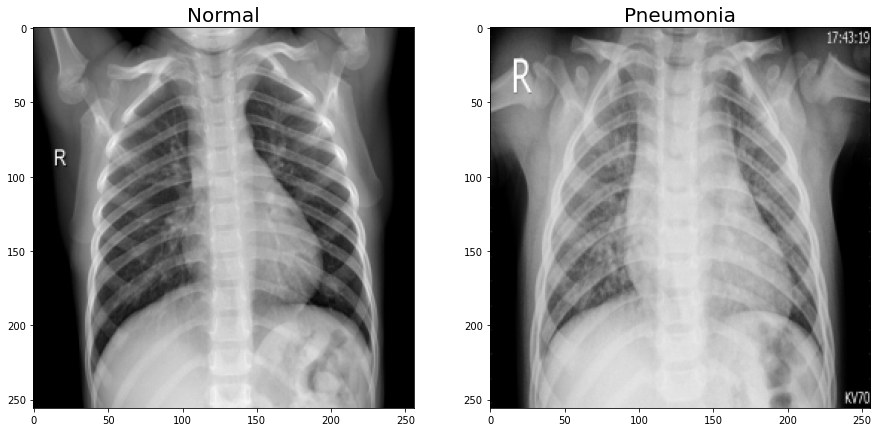

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,9))
axs[0].set_title("Normal", fontsize="20")
axs[0].imshow(x_raysKMeans[2].reshape(256,256), cmap=plt.get_cmap('gray'))
axs[1].set_title("Pneumonia", fontsize="20")
axs[1].imshow(x_raysKMeans[-2].reshape(256,256), cmap=plt.get_cmap('gray'))

fig.show()

From the images above, we can clearly see that lungs with pneumonia look more cloudy than healthy lungs. When observing the images, the cloudiness of the lungs are a common difference between normal and infected lungs.

In [ ]:
#shuffle
np.random.shuffle(x_raysKMeans)
np.random.shuffle(x_raysPCA)

In [ ]:
#Reshape array to 1D nparray
x_raysKMeans = x_raysKMeans.reshape(5216, -1)/255

In [ ]:
#Reshape array to 1D nparray and take transpose to create column vectors
x_raysPCA = x_raysPCA.reshape(5216, -1)/255
x_raysPCA = x_raysPCA.T

K-means:

Using K-means, we can attempt to find some underlying patterns for our images by assigning our images to certain clusters. We know that the dataset contains x-rays of both healthy and infected lungs and from the visualization, we can clearly see a difference in cloudiness. So we can train our model to try and identify this difference.

In [ ]:
#Helper functions for KMeans
def calcSqDistances(X, Kmus):
    res = np.zeros((X.shape[0], Kmus.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Kmus.shape[0]):
            res[i, j] = np.linalg.norm(X[i] - Kmus[j])
    return res

def determineRnk(sqDmat):
    Rnk = np.tile(0, (sqDmat.shape[0], sqDmat.shape[1]))
    for i in range(sqDmat.shape[0]):
        index = np.argmin(sqDmat[i])
        Rnk[i][index] = 1
    
    return Rnk

def recalcMus(X, Rnk):
    recalc = np.zeros((Rnk.shape[1], X.shape[1]))
    
    for i in range(Rnk.shape[1]):
        recalc[i,:] = np.sum((np.array([Rnk[:,i]]).T) * X, axis = 0)/(np.sum(Rnk[:,i], axis = 0))
    return recalc

In [ ]:
def runKMeans(matrix, K):
    #load data file specified by fileString from Bishop book
    start = time.time()
    X = matrix

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
#         plotCurrent(X, Rnk, Kmus)
#         time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)





        #check to see if the cluster centers have converged.  If so, break.
        diff = np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1))))
        print(diff)
        if diff < 1e-6:
            print(iter)
            break

    # plotCurrent(X, Rnk, Kmus)
    end = time.time()
    print("Total time: {}".format(end - start))
    return Kmus

In [ ]:
xray_kmeans = runKMeans(x_raysKMeans, 2)

15531.753746708018
1276.7736705800455
922.3660149134015
660.8573369942593
524.8289985679669
402.91106919965176
315.0110032229563
252.5270806819879
190.7987099393874
116.34958520706283
94.97826491308435
61.599106666732744
45.50841102984319
42.06795875291982
39.71521604829938
53.91094971481723
39.06728171794597
28.313560981116865
16.26347438923846
27.41938466167302
20.772565726567382
11.325282741050465
3.967461512583372
6.677922877439467
5.52415789433011
0.0
25
Total time: 134.02353286743164


Results from K-Means:

We can try to cluster K-means with 2 clusters (normal and pneumonia) to determine if K-means with 2 clusters is enough.

Not all clusters have enough images
No more pictures in cluster 1
No more pictures in cluster 1
No more pictures in cluster 1
No more pictures in cluster 1
No more pictures in cluster 1


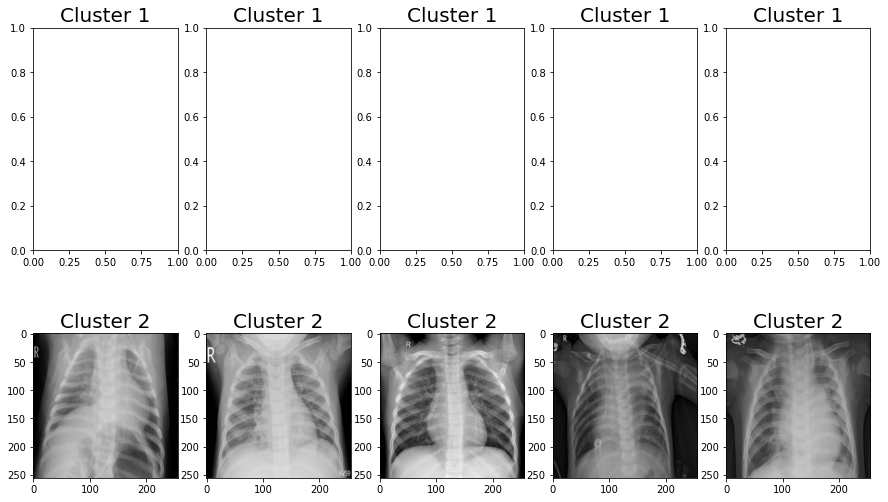

In [ ]:
indices = []

for i in range(2):
  indices.append([])

i = 0
j = 0
while i < 5*2:
    if (j == xray_kmeans.shape[1]):
        print("Not all clusters have enough images")
        break
    val = max(xray_kmeans[:,j])
    pos = np.where(xray_kmeans[:,j] == val)[0][0]
    if (len(indices[pos]) != 5):
        indices[pos].append(j)
        i += 1
        
    j += 1

fig, axs = plt.subplots(2, 5, figsize=(15,9))
for col in range(5):
      try:
        axs[0][col].set_title("Cluster 1", fontsize="20")
        axs[0][col].imshow(x_raysKMeans[indices[0][col]].reshape(256,256), cmap=plt.get_cmap('gray'))
      except:
        print("No more pictures in cluster 1")

      try:
        axs[1][col].set_title("Cluster 2", fontsize="20")
        axs[1][col].imshow(x_raysKMeans[indices[1][col]].reshape(256,256), cmap=plt.get_cmap('gray'))
      except:
        print("No pictures in cluster 2")

fig.show()

In [ ]:
print(xray_kmeans)

[[0.16427214 0.16929521 0.18952311 ... 0.06154821 0.06332491 0.07058376]
 [0.21668904 0.22654227 0.24546137 ... 0.07835704 0.0792794  0.08656882]]


From the results above, it doesn't seem like K-means with 2 clusters isn't enough to find any underlying patterns. Lets try 4.

In [ ]:
# four_clusters = runKMeans(x_raysKMeans, 4)

19933.225284000386
5513.673884572316
2605.5260732138613
1658.6607976477242
1235.7498307348503
921.0113165698484
848.5219551423678
859.9833261727816
742.9562423163663
735.9010055494527
679.8580855446857
570.1084070994028
405.70053528309563
342.1554771661469
305.1526483258072
212.01439932833463
148.31792652040488
107.12511616797967
88.79035220390554
83.81798462322104
51.69999323292316
14.623452269748604
7.198946831865435
0.0
23
Total time: 245.70328855514526


In [ ]:
# indices = []

# for i in range(4):
#   indices.append([])

# i = 0
# j = 0
# while i < 5*4:
#     if (j == xray_kmeans.shape[1]):
#         print("Not all clusters have enough images")
#         break
#     val = max(four_clusters[:,j])
#     pos = np.where(four_clusters[:,j] == val)[0][0]
#     if (len(indices[pos]) != 5):
#         indices[pos].append(j)
#         i += 1
        
#     j += 1

# print(indices)

Not all clusters have enough images
[[0.14243503 0.15449645 0.19296294 ... 0.03756398 0.04084267 0.0505007 ]
 [0.1946527  0.19237219 0.20147793 ... 0.08936413 0.09249617 0.10230661]
 [0.1878385  0.20189417 0.21553856 ... 0.04482    0.04273178 0.04638978]
 [0.25896958 0.26201117 0.2729032  ... 0.1273816  0.12823968 0.13371308]]
[[34, 35, 36, 37, 38], [], [32736, 32737, 32992, 32993, 33248], [0, 1, 2, 3, 4]]


PCA:


In [ ]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort, lambd

#Helper function to normalize matrix

def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

#Helper function to plot skree plot of lambdas

def skree(lambd):
    plt.plot(np.arange(len(lambd)) + 1, lambd, 'ro-', linewidth = 2)
    plt.title("Scree Plot")
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue")
    return

#Helper function to return variance explained and cumulataive sum of variance

def explained_variance(eigen_values):

  #explains how much of the data each component describes 
    var_exp = [(i/sum(eigen_values))*100 for i in eigen_values]
  
  #cumsum of var_exp for easier visualization
    cumsum_var = np.cumsum(var_exp)

    return var_exp, cumsum_var

#Helper function to viewcolumn vectors

def viewcolumn(columnvector):
    plt.imshow(columnvector.reshape(
        [256, 256], order='F'), cmap=plt.get_cmap('gray'))
    plt.show()

#Helper function to retrive indice where threshold variance is explained
#e.g. returns i = 4 if first 5 components explain threshold variance

def indexfinder(cumsum, threshold):
    for i in range(len(cumsum)):
        if cumsum[i] >= threshold:
            return i

In [ ]:
x_raysPCA.shape

(65536, 5216)

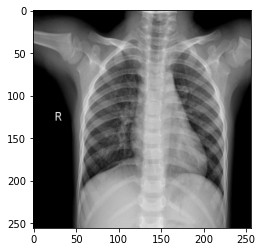

In [ ]:
viewcolumn(x_raysPCA[:,0])

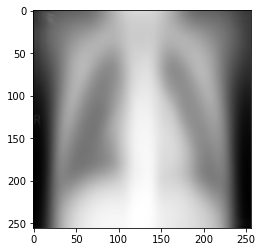

In [ ]:
mean_xrays = np.mean(x_raysPCA, axis = 1)[:,None]
viewcolumn(mean_xrays)

In [ ]:
A = (x_raysPCA - mean_xrays).real.astype(np.float32)
cov = np.divide(A.T@A, 5216)

In [ ]:
eigvals, V = np.linalg.eig(cov)
Vsort, Dsort, lambd = eigsort(V, eigvals)

C:\Users\GIRISH~1\AppData\Local\Temp/ipykernel_20268/1229958939.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  Vsort[:,i] = V[:,index[i]]


In [ ]:
U = A @ Vsort
U = normc(U)

D:\anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


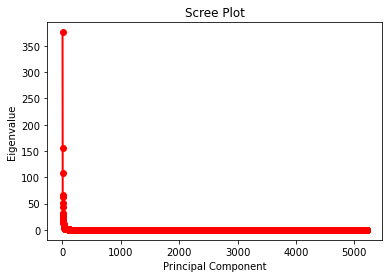

In [ ]:
#Skree plot
#Elbow at near right angle, extreme drop off of variance explained by components 
#following elbow
skree(lambd)

In [ ]:
exp, cumsum = explained_variance(eigvals)
cumsum

array([ 25.24716782+0.j,  35.67791557+0.j,  42.91349134+0.j, ...,
        99.9995983 +0.j,  99.99979919+0.j, 100.        +0.j])

In [ ]:
indexfinder(cumsum, 96)

647

In [ ]:
reduced_U = U[:625]
x_rays_temp = x_raysPCA[:,:625] - mean_xrays

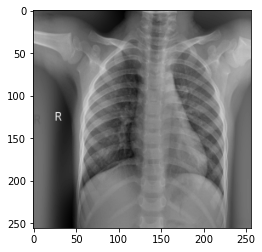

(65536, 625)

In [ ]:
viewcolumn(x_rays_temp[:,0])
reduced_U.shape
x_rays_temp.shape

In [ ]:
reduced_xrays = reduced_U.T @ x_rays_temp[:625]

In [ ]:
zhat = U[:,:625] @ reduced_xrays[:625] + mean_xrays

In [ ]:
#shape comparisons
reduced_xrays.shape, x_raysPCA.shape, zhat.shape

((5216, 625), (65536, 5216), (65536, 625))

KMeans with PCA:

Before we saw that 2 clusters wasn't enough for K-Means. We can try again this time using PCA.

In [ ]:
#KMeans on PCA reduced xrays, significantly faster
reduced_test = runKMeans(reduced_xrays, 2)

58.023733157975656
36.00686187054965
24.25113044653566
18.742607777453667
14.998023985898966
8.689804814171255
6.131390885923375
2.101500972505629
2.457667822782312
0.0
9
Total time: 0.8910062313079834


In [ ]:
print(reduced_test.shape)

(2, 625)


In [ ]:
#Initialize cluster arrays for visualization
cluster1, cluster2 = [], []

In [ ]:
#Retrieving image indices that are in cluster 1 and 2

i = 0
j = 0
while i < 20:
    if (reduced_test[:,j][0] < reduced_test[:,j][1]):
            cluster2.append(j)
            i += 1
    j += 1
j = 0
i = 0
while i < 20:
    if (reduced_test[:,j][0] > reduced_test[:,j][1]):
            cluster1.append(j)
            i += 1
    j += 1

In [ ]:
#cluster1, cluster2

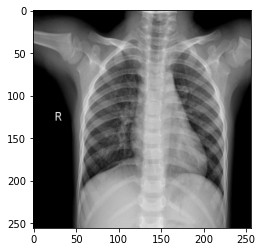

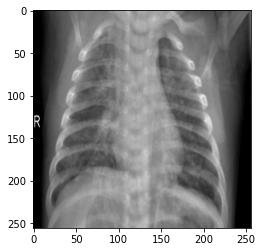

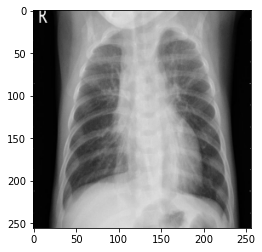

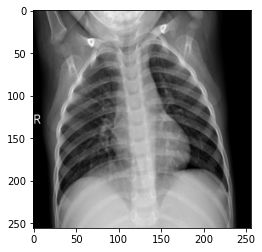

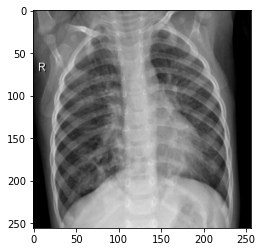

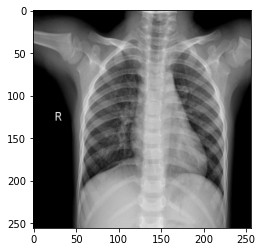

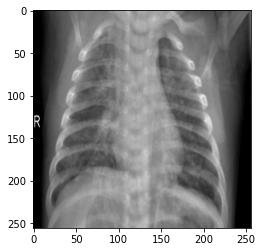

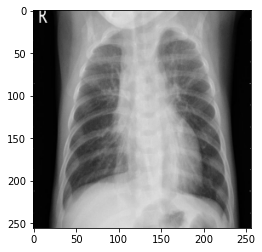

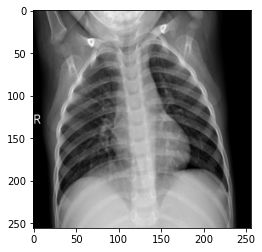

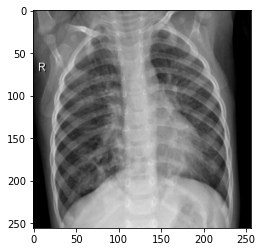

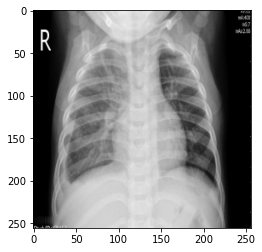

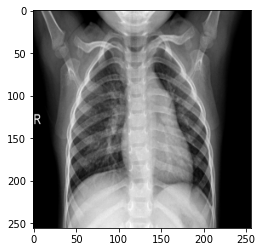

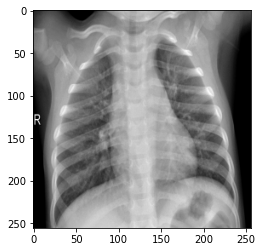

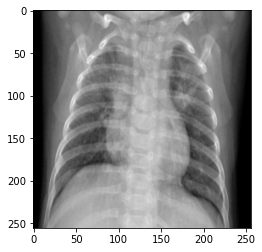

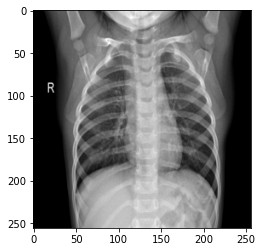

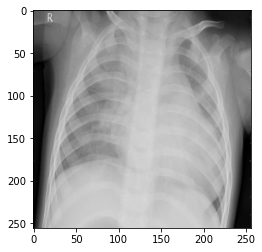

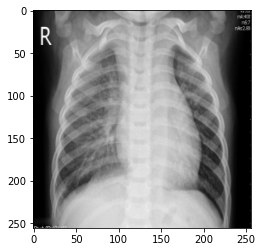

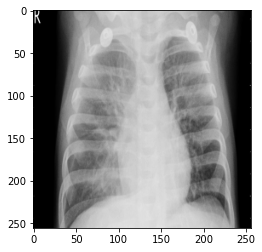

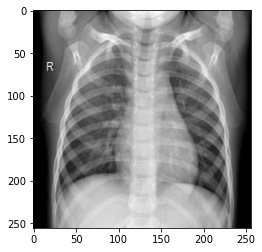

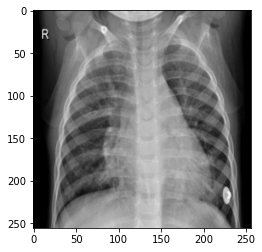

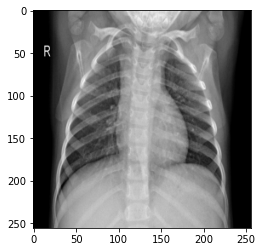

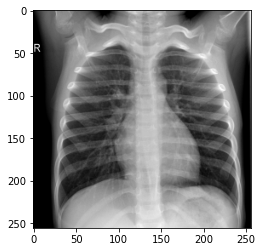

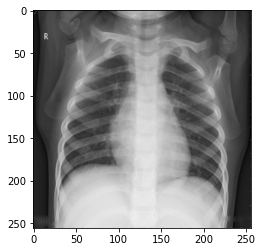

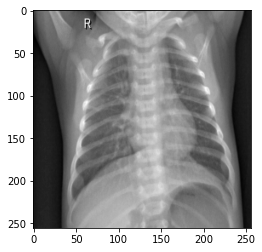

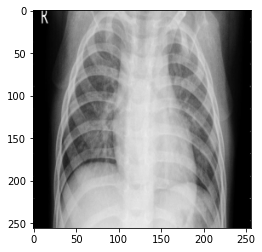

In [ ]:
#visualizing cluster 1
for i in cluster1:
    viewcolumn(x_raysPCA[:,i])

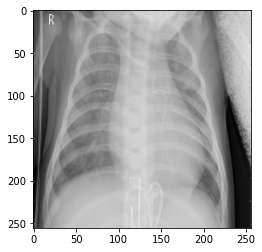

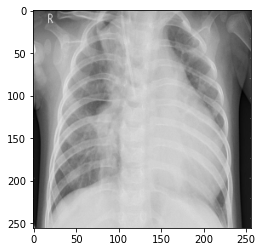

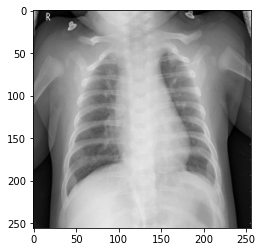

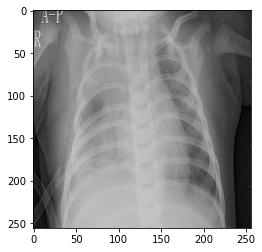

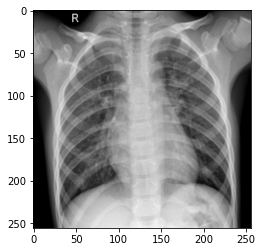

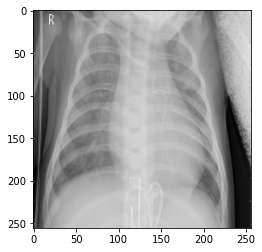

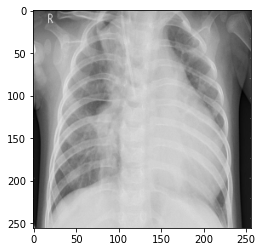

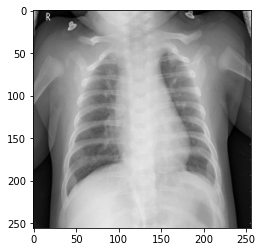

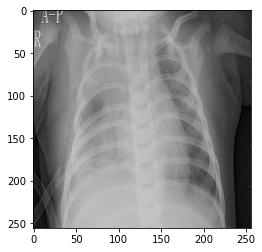

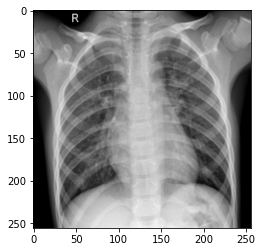

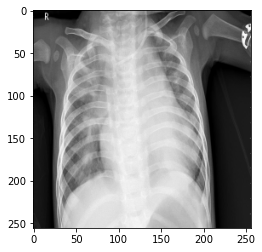

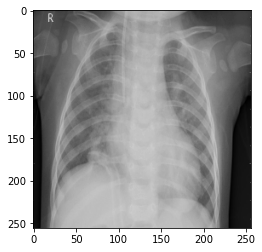

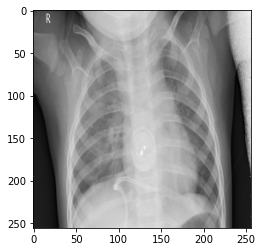

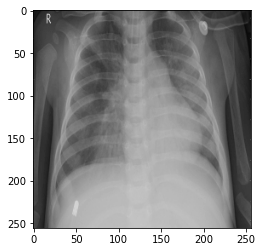

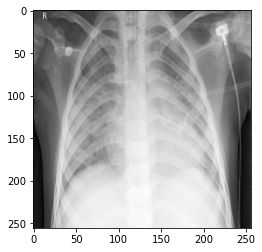

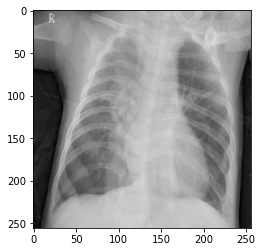

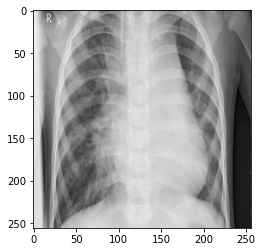

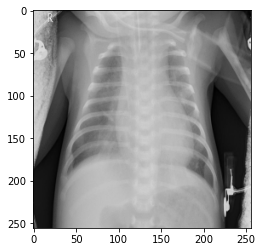

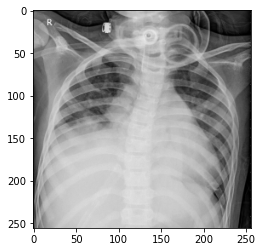

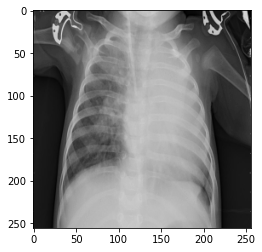

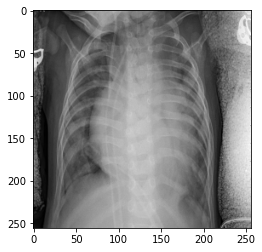

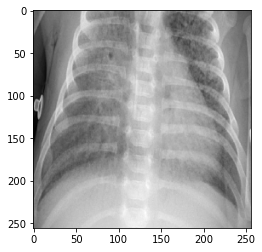

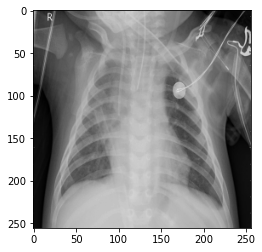

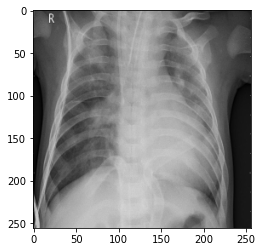

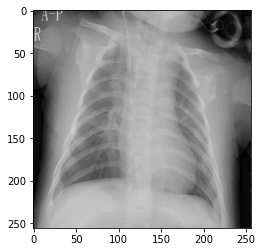

In [ ]:
jujupyter#Visualizing cluster 2
for i in cluster2:
    viewcolumn(x_raysPCA[:,i])

In [ ]:
#Time test
runKMeans(x_raysKMeans[:625], 10)

53251.29310715979
12975.70915035459
7908.927393615612
5826.213383545121
3000.860843674675
2053.139975271165
1905.5209200995841
1464.4574558468757
1277.6668805852053
1123.76893523213
1057.3896109636805
1091.0537855528744
327.3103373964699
139.59763307512657
0.0
14
Total time: 27.87922692298889


array([[0.20495356, 0.21093911, 0.20495356, ..., 0.07894737, 0.08059856,
        0.08864809],
       [0.10508578, 0.12113971, 0.17432598, ..., 0.03498775, 0.03541667,
        0.03909314],
       [0.07809331, 0.08803245, 0.16849222, ..., 0.01913455, 0.01744422,
        0.02393509],
       ...,
       [0.14235294, 0.1627451 , 0.22901961, ..., 0.01114846, 0.02196078,
        0.05355742],
       [0.29201681, 0.29304388, 0.29589169, ..., 0.14505135, 0.14318394,
        0.13851541],
       [0.31563025, 0.31596639, 0.3167507 , ..., 0.15282913, 0.16515406,
        0.17736695]])

In [ ]:
runKMeans(reduced_xrays, 10)

172.548301806466
193.54715038394357
197.63810299087348
249.679148828489
153.68880160764803
108.07196186188666
92.9641584199615
68.62131761830207
116.43846526061128
97.91677458202554
17.3263636747444
19.844209690354212
19.525966341417355
17.593108785327626
12.066758760760635
10.782612597227022
10.909322234621964
3.3369120178959886
4.584795608368188
7.9425412435512275
7.3655899356395444
3.3311303519046063
3.9505813336666753
7.531472184609349
5.927282149886446
1.1652520774346442
0.053897360992930805
0.05017256393514186
0.06738033964097287
0.04779679984287408
0.04906309992657764
0.035151801017124146
0.04582766276850441
0.05720516734821899
0.05801937158360646
0.05304869120831372
0.04575043405401399
0.03867836528848908
0.04982023086504363
0.051984800443810306
0.26112227643784713
0.05030118151262209
0.031158436753749057
0.025064619475766225
0.030657918770905013
0.015589391799456813
0.2666613084903217
0.02782753547673116
0.01993179426183235
0.010244345523390253
0.011636332185788856
0.020114526

array([[ 0.14683697,  0.3478942 , -0.28307379, ..., -0.63881909,
        -0.35724167,  0.27039356],
       [-0.17358937, -0.32635436,  0.32999286, ...,  0.69332556,
         0.30867625, -0.27247052],
       [ 0.03555581, -0.06565769, -0.0323348 , ...,  0.06545201,
         0.15379909, -0.0135928 ],
       ...,
       [-0.07545898, -0.11157161,  0.15335481, ...,  0.25279684,
         0.04160926, -0.12047103],
       [-0.00645457, -0.00903682,  0.01161287, ...,  0.01813968,
         0.00520754, -0.00953467],
       [ 0.03638274,  0.1135332 , -0.11221515, ..., -0.21984555,
        -0.05501013,  0.11174415]])